<a id="0"></a> <br>
 # Table of Contents  
1. [Import necessary libraries and load in scaled train & test data](#1)     
1. [Dummy Regressor "Model"](#2)     
    1. [Determine best summary statistic to use for Dummy Regressor](#3) 
    1. [Implementation of Dummy Regressor using the mean](#4) 
1. [Linear Regression Model](#5)     
    1. [Linear Regression Model using all features in dataset](#6)     
    1. [Linear Regression Model using feature selection](#7)     
1. [Tree-Based Models](#8)     
    1. [Decision Tree Models](#9)
      <br> 1. [Decision Tree Model using Default Parameters](#10) 
      <br> 2. [Decision Tree Model using RandomizedSearchCV for Hyperparameter Tuning](#11) 
    1. [Random Forest Models](#12) 
      <br> 1. [Random Forest Model using Default Parameters](#13) 
      <br> 2. [Random Forest Model using RandomizedSearchCV for Hyperparameter Tuning](#14)    
1. [Summary & Conclusions](#15)         

<a id="1"></a> 
### 1. Importing necessary libraries and load in scaled train & test data

In [2]:
#Loading in necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.dummy import DummyRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
import datetime
import pickle as pk

In [6]:
#Loading in necessary data
X_train_scaled = pd.read_csv('./cleaned_data/X_train_scaled.csv', index_col = 0)
X_test_scaled = pd.read_csv('./cleaned_data/X_test_scaled.csv', index_col = 0)
y_train = pd.read_csv('./cleaned_data/y_train.csv', index_col =0)
y_test = pd.read_csv('./cleaned_data/y_test.csv', index_col = 0)

In [36]:
#Review imports to ensure formatting is as expected 
X_train_scaled.head()

,Length,Diameter,Height,Weight,Shucked_Weight,Viscera_Weight,Shell_Weight,Sex_F,Sex_I,Sex_M
0,0.873989,0.860293,0.937882,0.944023,0.606259,0.905845,0.989585,1.528832,-0.704519,-0.764144
1,0.460982,0.693374,0.500199,0.511690,0.439462,0.609758,0.360296,-0.654094,-0.704519,1.308655
2,-0.043803,0.136980,0.646093,0.165359,-0.463810,0.287699,0.693946,-0.654094,-0.704519,1.308655
3,0.552762,0.526456,0.500199,0.597692,0.421499,0.698065,0.398307,-0.654094,-0.704519,1.308655
4,0.369203,0.359538,0.354304,-0.012455,-0.119951,-0.029166,-0.066270,-0.654094,-0.704519,1.308655


In [37]:
X_test_scaled.head()

,Length,Diameter,Height,Weight,Shucked_Weight,Viscera_Weight,Shell_Weight,Sex_F,Sex_I,Sex_M
0,0.231534,0.248259,0.500199,-0.027563,-0.350901,-0.138251,-0.028259,-0.654094,-0.704519,1.308655
1,1.470554,1.305408,1.521461,2.071342,1.494134,2.355112,1.623098,1.528832,-0.704519,-0.764144
2,0.919879,1.027211,1.083777,1.469331,1.437679,1.233099,1.158522,-0.654094,-0.704519,1.308655
3,0.415093,0.470817,0.500199,0.230442,0.390705,0.313671,0.187136,1.528832,-0.704519,-0.764144
4,0.231534,0.303898,0.062515,0.117710,-0.022439,-0.148640,0.313838,-0.654094,1.419408,-0.764144


In [38]:
y_train.head()

,Age
11735,12.0
21925,10.0
12389,12.0
12361,9.0
2357,12.0


In [39]:
y_test.head()

,Age
25384,10.0
37878,10.0
39380,10.0
43279,10.0
4762,13.0


In [8]:
#Transform each dataset in np array for modelling & flatten it
X_train = X_train_scaled.to_numpy()
X_test = X_test_scaled.to_numpy()
y_train = y_train.to_numpy().ravel()
y_test = y_test.to_numpy().ravel()

In [41]:
#Review shape to ensure transformation was successful
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((31748, 10), (13607, 10), (31748,), (13607,))

<a id="2"></a> 
### 2. Dummy Regressor "Model"

Before completing some actual modelling, let's use sklearn's DummyRegressor as a sanity check to see how using a simple estimator at predicting the target variable- Age. 

The estimator for the DummyRegressor can leverage several methods outlined below:

   - **mean** always predicts the mean of the training targets

   - **median** always predicts the median of the training targets

   - **quantile** always predicts a user provided quantile of the training targets

   - **constant** always predicts a constant value that is provided by the user  

Regardless of the method employed, the predict method of the DummyRegressor ignores the input data. If you recall from the exploratory data analysis, the Age distribution was close to a normal distribution with slight positive skew (right-skewed distribution). Also remember, that the Age values were not normalized as the target variable values but outliers were removed so our distribution may have changed slightly. Before selecting a method to use with DummyRegressor, let's review the distribution of the remaining Age values.

<a id="3"></a> 
#### 2A. Determine best summary statistic to use for Dummy Regressor

In [42]:
#Combine y_test & y_train to get combine
y_comb = np.concatenate((y_train, y_test), axis = 0)

In [43]:
#Inspect y_comb
y_comb.shape

(45355,)

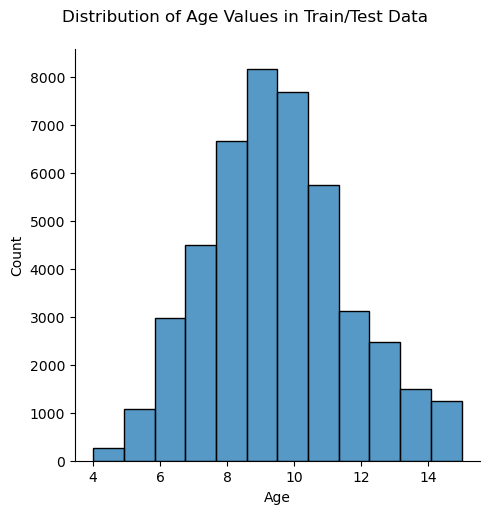

In [44]:
#Review distribution of Age values in training/testing data
x = sns.displot(y_comb, kde=False, bins=12, legend = False)
x.set_axis_labels("Age", "Count")
x.fig.suptitle("Distribution of Age Values in Train/Test Data")
x.fig.subplots_adjust(top=0.9)
plt.show()

Since our Age data distribution looks more normally distributed following removal of outliers performed during the exploratory analysis, we will use the "mean" method for the DummyRegressor. For a normal distribution, the mean is more representative of its central tendency.

<a id="4"></a> 
#### 2B. Implementation of Dummy Regressor using mean

In [45]:
#Use DummyRegressor with 'mean' method
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)

#Displaying the mean value of the Age distribution (i.e. our DummyRegressor constant predicted Age value)
dumb_reg.constant_

array([[9.50919743]])

In [46]:
#Determine coefficient of determination (R^2 value) using DummyRegressor on test data 
dumb_reg.score(X_test, y_test)

-1.2009058714124166e-06

For the coefficient of the determination, the best possible score is 1.0 and its value can be negative, when the model is worse than a constant value predictor (like our DummyRegressor mean predictor is in this case). A constant model that always predicts the expected value of y, disregarding the input features, should have an R^2 score of 0.0. 
<br>
<br>
This DummyRegressor estimator uses the mean of the training data. It seems that when run using our test data, the model performs slightly worse than expected for a constant value model (likely because the mean of the Age test data is slightly different than the mean of the Age training data). The DummyRegression constant predictor value of ~9.5 is representative of the mean of the combined Age test/training data distribution, however the distribution spans from ~4-15 so this isn't an adequate model to be descriptive for the whole entire range of possibilities so we must proceed with more advanced modelling.

<a id="5"></a> 
### 3. Linear Regression Modelling

<a id="6"></a> 
#### 3A. Linear Regression Model using all features in dataset

In [47]:
#Define Linear Regression Model
lm = LinearRegression()

#Fit model using train split
lm.fit(X_train, y_train)

LinearRegression()

In [48]:
#Make predictions using the model on both the train and test splits
lm_y_tr_pred = lm.predict(X_train)
lm_y_te_pred = lm.predict(X_test)

In [49]:
#Assess the performance of the Linear Regression Model
#Coefficient of Determination for train/test predictions - amount of variance explained by the model
lm_r2 =  r2_score(y_train, lm_y_tr_pred), r2_score(y_test, lm_y_te_pred)
lm_r2

(0.5407640913250782, 0.5334227717343935)

In [50]:
#Mean absolute error -average of the absolute errors
lm_mae = mean_absolute_error(y_train, lm_y_tr_pred), mean_absolute_error(y_test, lm_y_te_pred)
lm_mae

(1.2015041490493288, 1.2033599295792274)

In [51]:
#Mean squared error - average of the square of the errors
lm_mse = mean_squared_error(y_train, lm_y_tr_pred), mean_squared_error(y_test, lm_y_te_pred)
lm_mse

(2.4714135158683166, 2.4760407018265043)

In [52]:
#use cross-validation to assess performance of model
lm_cv = cross_validate(lm, X_train, y_train, scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'], cv = 5)

In [53]:
#Review test scores for 5-fold cross validation of linear model
lm_cv.keys()

dict_keys(['fit_time', 'score_time', 'test_r2', 'test_neg_mean_absolute_error', 'test_neg_mean_squared_error'])

In [54]:
#Review r2 values for 5-fold cross validation of linear model
lm_cv['test_r2']

array([0.54495549, 0.54575029, 0.54505785, 0.53358551, 0.5325107 ])

As a note, sklearn metrics for scoring the mean absolute error and the mean squared error when using cross-validation by default return the negative values. To make these outputs be comparable to our previous metrics calculated above each array will be multiplied by -1.

In [55]:
#Review mean absolute error for 5-fold cross validation of linear model
-1 * lm_cv['test_neg_mean_absolute_error']

array([1.18788973, 1.20823249, 1.19635913, 1.20455996, 1.21121292])

In [56]:
#Review mean squared error for 5-fold cross validation of linear model
-1 * lm_cv['test_neg_mean_squared_error']

array([2.43728216, 2.47950488, 2.46295756, 2.46991431, 2.51502736])

A standard linear regression model didn't perform very well - coefficient of determination values were ~ 0.55. Predicted age values were ~ 1.20 units away from actual value via mean absolute error.

The previous linear model, leveraged all features in the dataset. Let's try to see if using a subset of these features through feature selection improves the performance of the linear model. 

<a id="7"></a> 
#### 3B. Linear Regression Model using feature selection

In [57]:
#Perform feature selection, select all features to see which features are most important
fs = SelectKBest(f_regression, k = "all")

In [58]:
#Fit feature selection on training data
fs.fit(X_train, y_train)

SelectKBest(k='all', score_func=<function f_regression at 0x00000278AF333700>)

In [59]:
#Make predictions using the model with feature selection on both the train and test splits
fs_y_tr_pred = lm.predict(X_train)
fs_y_te_pred = lm.predict(X_test)

Feature 0: 21940.055086
Feature 1: 22856.130214
Feature 2: 24085.417556
Feature 3: 19100.458821
Feature 4: 12597.815357
Feature 5: 17590.727273
Feature 6: 25206.194051
Feature 7: 3024.040267
Feature 8: 13252.522294
Feature 9: 2109.020321


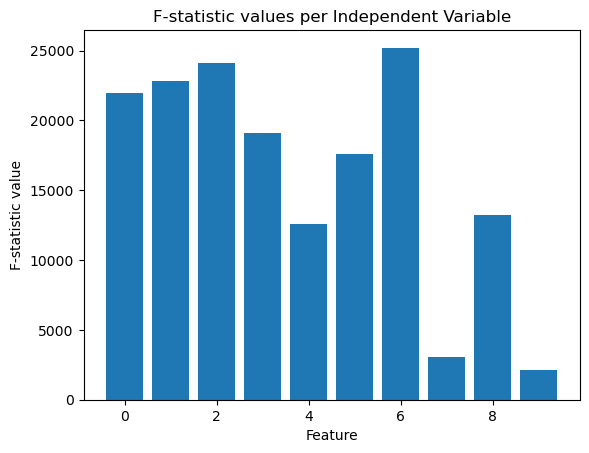

In [60]:
#What are scores for the features
for i in range(len(fs.scores_)):
 print('Feature %d: %f' % (i, fs.scores_[i]))

# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.xlabel('Feature')
plt.ylabel('F-statistic value')
plt.title('F-statistic values per Independent Variable')
plt.show()

It seems like 4 features stand out as having the highest F-statistic scores. Perhaps maybe using a lesser number of features might yield more success? Let's use a pipeline test and see which number of features yields the best results using GridSearch and cross-validation.

In [61]:
#Construct a pipeline to incorporate feature selection & linear regression
fs_lm_pipe = make_pipeline(SelectKBest(f_regression), LinearRegression())

In [62]:
#Inspect pipe's get_params() method to get a dictionary of available 
#parameters and print names using dictionary's keys() method
fs_lm_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'selectkbest', 'linearregression', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [63]:
#Specify parameter grid to search ideal number of features to include (i.e testing from 1 to all independent variables)
k = [k+1 for k in range(X_train.shape[1])]
grid_params = {'selectkbest__k': k}

In [64]:
#Use GridSearch to systematically test each different number of features possible to include in the model
#n_jobs = -1 means leveraging all processors to run jobs in parallel
lr_grid_cv = GridSearchCV(fs_lm_pipe, param_grid = grid_params, scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'], cv = 5, n_jobs = -1, refit = 'r2')

In [65]:
#Use fit method to perform GridSearch of # of features plus 5-fold cross validation on test data
lr_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x00000278AF333700>)),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             refit='r2',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_mean_squared_error'])

In [66]:
#Review lr_gri_cv.cv_results_ attribute
lr_grid_cv.cv_results_

{'mean_fit_time': array([0.01237454, 0.01190991, 0.01435876, 0.0142436 , 0.01500626,
        0.01467295, 0.01503334, 0.01693397, 0.01781545, 0.01723642]),
 'std_fit_time': array([0.00138229, 0.0040665 , 0.00104003, 0.00238786, 0.00031431,
        0.0013646 , 0.00086399, 0.00205056, 0.00070393, 0.0019291 ]),
 'mean_score_time': array([0.00180197, 0.00160141, 0.0018003 , 0.00263081, 0.00182204,
        0.00185523, 0.00145755, 0.00165734, 0.00245476, 0.00219965]),
 'std_score_time': array([0.00040164, 0.00049062, 0.00040007, 0.00180339, 0.00072389,
        0.00076786, 0.00044789, 0.00054189, 0.00084292, 0.00074782]),
 'param_selectkbest__k': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'params': [{'selectkbest__k': 1},
  {'selectkbest__k': 2},
  {'selectkbest__k': 3},
  {'selectkbest__k': 4},
  {'selectkbest__k': 5},
  {'

In [67]:
#Extract list of mean coefficient of determination, mean absolute error, & mean squared error for testing of each # 
#of features in a linear model using GridSearch/5 fold cross-validation
score_mean_r2 = lr_grid_cv.cv_results_['mean_test_r2']
score_mean_abs_error = -1 * lr_grid_cv.cv_results_['mean_test_neg_mean_absolute_error']
score_mean_sq_error = -1 * lr_grid_cv.cv_results_['mean_test_neg_mean_squared_error']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

In [68]:
#Review mean coefficient of determination scores
for i in range(len(score_mean_r2)):
    print('Mean coefficient of determination scores for 5-fold cross-validation using', i + 1, 'features:', score_mean_r2[i])

Mean coefficient of determination scores for 5-fold cross-validation using 1 features: 0.44243015716044776
Mean coefficient of determination scores for 5-fold cross-validation using 2 features: 0.4561697895854908
Mean coefficient of determination scores for 5-fold cross-validation using 3 features: 0.4563602547146838
Mean coefficient of determination scores for 5-fold cross-validation using 4 features: 0.4572338531627203
Mean coefficient of determination scores for 5-fold cross-validation using 5 features: 0.4861709426739453
Mean coefficient of determination scores for 5-fold cross-validation using 6 features: 0.4861462779135901
Mean coefficient of determination scores for 5-fold cross-validation using 7 features: 0.509698678009717
Mean coefficient of determination scores for 5-fold cross-validation using 8 features: 0.5403538025423151
Mean coefficient of determination scores for 5-fold cross-validation using 9 features: 0.5403857849694951
Mean coefficient of determination scores for 5

In [69]:
#Review mean absolute error scores
for i in range(len(score_mean_abs_error)):
    print('Mean absolute error score for 5-fold cross-validation using', i + 1, 'features:', score_mean_abs_error[i])

Mean absolute error score for 5-fold cross-validation using 1 features: 1.3336279692092652
Mean absolute error score for 5-fold cross-validation using 2 features: 1.3137278792337703
Mean absolute error score for 5-fold cross-validation using 3 features: 1.3133615149881879
Mean absolute error score for 5-fold cross-validation using 4 features: 1.3127723741261903
Mean absolute error score for 5-fold cross-validation using 5 features: 1.2728951383958749
Mean absolute error score for 5-fold cross-validation using 6 features: 1.2729089788208654
Mean absolute error score for 5-fold cross-validation using 7 features: 1.2405998634529056
Mean absolute error score for 5-fold cross-validation using 8 features: 1.2019871493620495
Mean absolute error score for 5-fold cross-validation using 9 features: 1.2017667833188024
Mean absolute error score for 5-fold cross-validation using 10 features: 1.2017681603104042


In [70]:
#Review mean square error scores
for i in range(len(score_mean_sq_error)):
    print('Mean squre error score for 5-fold cross-validation using', i + 1, 'features:', score_mean_sq_error[i])

Mean squre error score for 5-fold cross-validation using 1 features: 2.9999742773486235
Mean squre error score for 5-fold cross-validation using 2 features: 2.926099793243527
Mean squre error score for 5-fold cross-validation using 3 features: 2.92507075435089
Mean squre error score for 5-fold cross-validation using 4 features: 2.9203654991581316
Mean squre error score for 5-fold cross-validation using 5 features: 2.7647472655397882
Mean squre error score for 5-fold cross-validation using 6 features: 2.764879406454887
Mean squre error score for 5-fold cross-validation using 7 features: 2.638103350719182
Mean squre error score for 5-fold cross-validation using 8 features: 2.473033695890632
Mean squre error score for 5-fold cross-validation using 9 features: 2.4728625280709715
Mean squre error score for 5-fold cross-validation using 10 features: 2.472859249528443


In [71]:
#Determine which number of features in linear model yields the best performance
lr_grid_cv.best_params_

{'selectkbest__k': 10}

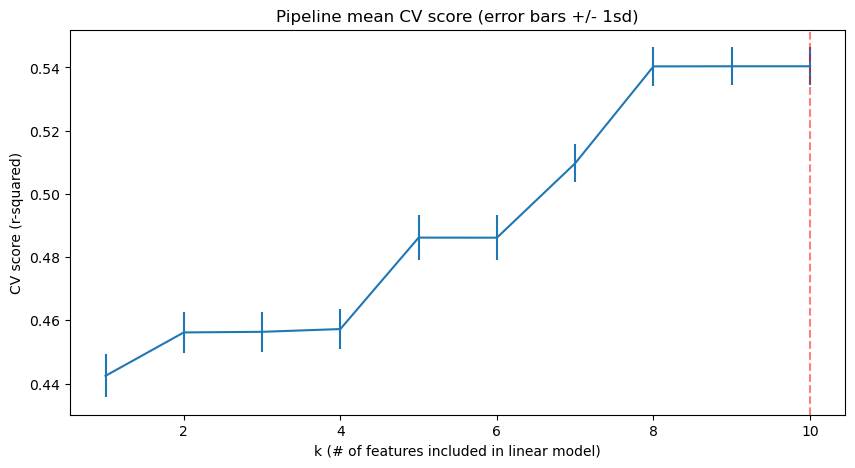

In [72]:
#Plot showing how mean coefficient of determination values vary when changing number of features
#using 5-fold cross-validation on training data
#Error bars should +/- 1 std for each coefficient of determination value
best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean_r2, yerr=lr_grid_cv.cv_results_['std_test_r2'])
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k (# of features included in linear model)')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)')
plt.show()

Using 5-fold cross-validation and GridSearch to test each possible number of features that could be included in the linear model shows that the optimum model performance occurs when all 10 features of the model are included. When all 10 features of the linear model are included, 5-fold cross-validation testing yielded a mean coefficient of determination of ~0.55 as indicated by the red-dashed vertical line in the above plot.

In [73]:
#Use the fitted GridSearch object's best estimator attribute to then selectkbest with get_support() method to
#get a logical mask for features selected in the best performing model (in this case all 10 features)
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()

In [74]:
#Obtain the linear model coefficients from the `coef_` attribute and store in `coefs`,
#get the matching feature names from the column names of the dataframe,
#and display the results as a pandas Series with `coefs` as the values and `features` as the index
coefs = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
features = X_train_scaled.columns[selected]
pd.Series(coefs, index= features).sort_values(ascending=False)

Shell_Weight      1.164975e+00
Weight            9.175587e-01
Height            5.471116e-01
Diameter          5.126607e-01
Length            2.354309e-01
Viscera_Weight   -1.975060e-01
Shucked_Weight   -1.959332e+00
Sex_F            -1.520247e+11
Sex_I            -1.562477e+11
Sex_M            -1.601018e+11
dtype: float64

Shell weight appears to be the feature with the greatest importance to the linear model. 

In [75]:
#Calculate linear regression model performance metrics using all 10 features fitted on test data
#best_estimator_ attribute selects 10 feature model as this was the model that yielded best results for coeff determination during GridSearch
best_lm_r2 = r2_score(y_test, lr_grid_cv.best_estimator_.predict(X_test))
best_lm_mean_abs_error = mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
best_lm_mean_sq_error = mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))

In [76]:
#Linear regression model metrics for model using all 10 features on test data
print('Coefficient of Determination for Actual vs Predicted Test Data, Linear Model with all 10 features:', round(best_lm_r2, 5))
print('Mean Absolute Error for Actual vs Predicted Test Data, Linear Model with all 10 features:', round(best_lm_mean_abs_error, 5))
print('Mean Square Error for Actual vs Predicted Test Data, Linear Model with all 10 features:', round(best_lm_mean_sq_error, 5))

Coefficient of Determination for Actual vs Predicted Test Data, Linear Model with all 10 features: 0.53342
Mean Absolute Error for Actual vs Predicted Test Data, Linear Model with all 10 features: 1.20336
Mean Square Error for Actual vs Predicted Test Data, Linear Model with all 10 features: 2.47604


<a id="8"></a> 
### 4. Tree-Based Models

Now, let's explore a few of the tree modelling algorithms. Below is a graphic describing common tree algorithms in terms of increasing complexity. We will start simple and try Decision Trees.

**Source: Kaggle**

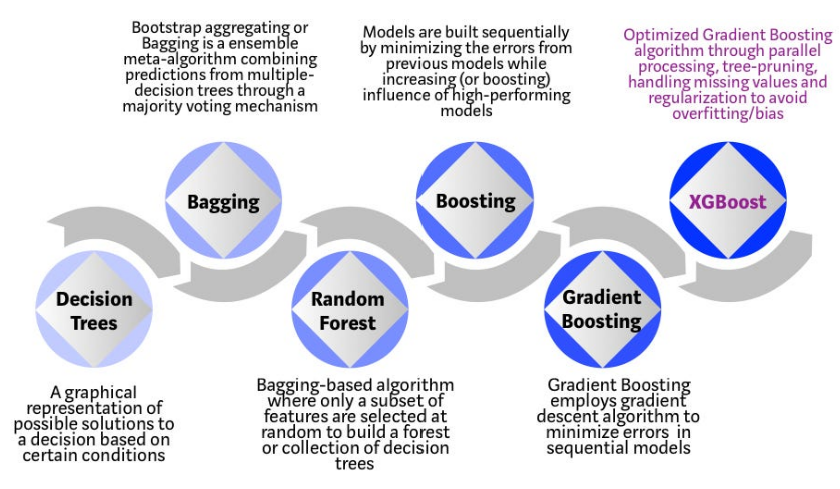

<a id="9"></a> 
#### 4A. Decision Tree Model

<a id="10"></a> 
#### 4A.1 Decision Tree Model using Default Parameters

In [4]:
#Create Decision Tree Regressor - no max tree depth specified, absolute error is function to measure quality of split
dt = DecisionTreeRegressor(criterion = 'absolute_error', random_state = 1234)

In [9]:
#Perform 5-fold cross validation to estimate performance of initial Decision Tree Regressor model on training data
dt_cv_scores = cross_validate(dt, X_train, y_train, cv = 5)

In [79]:
#Absolute error for initial Decision Tree Regressor during 5-fold cross-validation
print('Mean Absolute Error for Initial Decision Tree Regressor Model (No Max Tree Depth Specified), 5-fold Cross Validation:', round(np.mean(dt_cv_scores['test_score']), 5))

Mean Absolute Error for Initial Decision Tree Regressor Model (No Max Tree Depth Specified), 5-fold Cross Validation: 0.11195


In [80]:
#Inspect Decision Tree Model with Default Parameters
dt.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'absolute_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1234,
 'splitter': 'best'}

<a id="11"></a> 
#### 4A.2 Decision Tree Model using RandomizedSearchCV for Hyperparameter Tuning

In [84]:
#Use RandomizedSearch with cross-validation to determine the best set of hyperparameters to use for Decision Tree Regressor model
#Since we are searching a larger grid (i.e. including more hyperparameters & a range for each), RandomizedSearch is more efficient to use
grid_params = {"splitter":["best","random"],
            "max_depth" : [5, 10, 20, 40, 80, 120],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90]}

dt_grid_cv = RandomizedSearchCV(dt, param_distributions = grid_params, cv = 5, n_jobs = -1, n_iter = 60)

In [85]:
#Use fit method to start GridSearch/cross-validation
dt_grid_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=DecisionTreeRegressor(criterion='absolute_error',
                                                   random_state=1234),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'max_depth': [5, 10, 20, 40, 80, 120],
                                        'max_features': ['auto', 'log2', 'sqrt',
                                                         None],
                                        'max_leaf_nodes': [None, 10, 20, 30, 40,
                                                           50, 60, 70, 80, 90],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_weight_fraction_leaf': [0.1, 0.2,
                                                                     0.3, 0.4,
                                                                     0.5],
            

In [86]:
#Print best parameter for max depth of the Decision Tree Regressor found via GridSearch/cross-validation
dt_grid_cv.best_params_

{'splitter': 'random',
 'min_weight_fraction_leaf': 0.1,
 'min_samples_leaf': 7,
 'max_leaf_nodes': None,
 'max_features': 'auto',
 'max_depth': 40}

In [87]:
#Print absolute error scores for Decision Tree Regressor with max_depth = 10
dt_best_cv_results = cross_validate(dt_grid_cv.best_estimator_, X_train, y_train, cv = 5)

dt_best_scores = dt_best_cv_results['test_score']

print('Mean absolute error for Decision Tree Regressor Model with RandomizedSearch Hyperparameter Tuning, 5-fold Cross Validation: ', round(np.mean(dt_best_scores), 5))

Mean absolute error for Decision Tree Regressor Model with RandomizedSearch Hyperparameter Tuning, 5-fold Cross Validation:  0.44553


Well it seems that our default Decision Tree Model had a lower mean absolute error than the Decision Tree Model created using Hyperparameter Tuning with RandomizedSearchCV. The default Decision Tree Model also performed more favorably than any of our Linear Regression Models. 

Let's see if a random forest model can achieve better performance...

<a id="12"></a> 
#### 4B. Random Forest Model

<a id="13"></a> 
#### 4B.1 Random Forest Model using Default Parameters

In [88]:
#Create RandomForest Regressor - standard parameters, absolute error specified as function to measure quality of split
rf = RandomForestRegressor(criterion = 'absolute_error', random_state = 1234)

In [89]:
#Perform 5-fold cross validation to estimate performance of initial Random Forest Regressor model on training data
rf_cv_scores = cross_validate(rf, X_train, y_train, cv = 5)

In [90]:
#Absolute error for Random Forest Regressor during 5-fold cross-validation
print('Mean Absolute Error for Initial Random Forest Regressor, 5-fold Cross Validation:', round(np.mean(rf_cv_scores['test_score']), 5))

Mean Absolute Error for Initial Random Forest Regressor, 5-fold Cross Validation: 0.54757


In [93]:
#Inspect Random Forest Model with Default Parameters
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'absolute_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1234,
 'verbose': 0,
 'warm_start': False}

<a id="14"></a> 
#### 4B.2 Random Forest Model using RandomizedSearchCV for Hyperparameter Tuning

In [91]:
#Use RandomizedSearch with cross-validation to determine the best set of hyperparameters to use for Random Forest Regressor model
#Since we are searching a larger grid (i.e. including more hyperparameters & a range for each), RandomizedSearch is more efficient to use
grid_params_rf = {'n_estimators': [25, 50, 100, 150], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9], 
    'max_leaf_nodes': [3, 6, 9]} 

rf_grid_cv = RandomizedSearchCV(rf, param_distributions = grid_params_rf, cv = 5, n_jobs = -1, n_iter = 60)

In [92]:
rf_grid_cv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(criterion='absolute_error',
                                                   random_state=1234),
                   n_iter=60, n_jobs=-1,
                   param_distributions={'max_depth': [3, 6, 9],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_leaf_nodes': [3, 6, 9],
                                        'n_estimators': [25, 50, 100, 150]})

In [94]:
#Absolute error for Random Forest Regressor during 5-fold cross-validation
print('Mean Absolute Error for Random Forest Regressor Model with RandomizedSearch Hyperparamter Tuning, 5-fold Cross Validation:', round(np.mean(rf_cv_scores['test_score']), 5))

Mean Absolute Error for Random Forest Regressor Model with RandomizedSearch Hyperparamter Tuning, 5-fold Cross Validation: 0.54757


<a id="15"></a> 
### 5. Summary & Conclusions

It seems like for this study the default Decision Tree model had the best performance based on the mean absolute error of any of the models trialed. For the purposes of crab age prediction, a mean absolute error of 0.11195 years is satisfactory performance for a model so this will be our final selection.

Before wrapping up, let's review the feature importances for the Decision Tree model to see which features had the greatest impact predicting crab age.

In [14]:
#Fit the decision tree default model on training data
dt.fit(X_train, y_train)

DecisionTreeRegressor(criterion='absolute_error', random_state=1234)

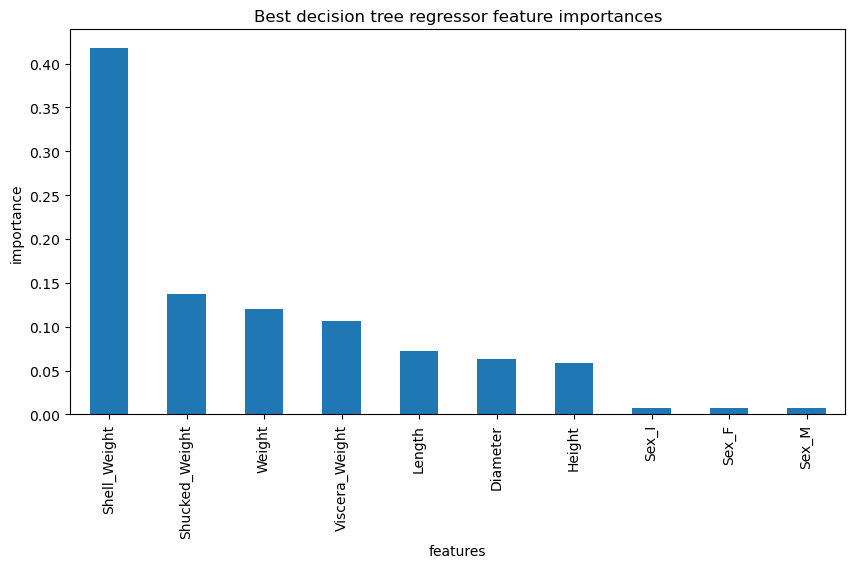

In [15]:
#Plot a barplot of the decision tree's feature importances
plt.subplots(figsize=(10, 5))
imps = dt.feature_importances_
rf_feat_imps = pd.Series(imps, index=X_train_scaled.columns).sort_values(ascending=False)
rf_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best decision tree regressor feature importances');

It appears that all of the weight related parameters- Shell_Weight, Shucked_Weight, Weight, and Viscera_Weight were the highest ranking features. Shell_Weight was noticeably higher importance though. Length, Diameter, and Height- the other physical size attributes were of lesser importance but comparable to one another. Gender played little role in the model's predictions.

Finally, let's save the model so it can be called and used in the future.

In [130]:
#Save the best model
best_model = dt
best_model.version = 1.0
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn.__version__
best_model.X_columns = [col for col in X_train_scaled.columns]
best_model.build_datetime = datetime.datetime.now()

In [140]:
#Save the model
with open("C:/Users/jlmar/OneDrive/Documents/GitHub/Capstone2_CrabAge/models/dt_crab_age_model.pkl", "wb") as file: 
    pk.dump(best_model, file)